# NCAA Embeddings
> Learning complex features of NCAA teams with limited data.


## Intro

One of my big projects this past year was preparing to my first Kaggle competition - both the NCAA [Men's](https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament) and [Women's](https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament) basketball tournaments! Unfortunately, the NCAA tournament was cancelled due to the Covid-19 pandemic. Regardless, working through my different ideas was a great way to learn some of the basics and nuances of training an ML model effectively.

I tried a few different types of models including a simple 2 layer neural net using [FastAI](https://docs.fast.ai/) and an ensemble model (XGBoost). These were relatively comprable and both required a similar level of feature engineering to get a good result (I think due to the limited data set - ~64 games per year since 2003 with the detailed game data). The results were fine, but I was wondering if there was a solution that could allow for less feature engineering and still give a reasonable result.

Enter embeddings... in this notebook I'm going to explore a simple Keras implementation of embeddings to represent each NCAA team (e.g. Duke 2019 $\neq$ Duke 2020). For now, I will use those embeddings to perform some exploratory analysis to verify that they have learned useful features and in a following notebook I will use these embeddings as input features to an NCAA tournament model. This work was inspired by [this Kaggle notebook](https://www.kaggle.com/abhijitbrahme/embedding-ncaa-model). Though the predictions aren't spectacular, I think the exploratory analysis shows that embeddings could be a useful feature if paired with more detailed data and a model refined to predict NCAA tournament games as opposed to regular season games.

**What you will see in this notebook at a high level:**
 - Brief data prep - we are only using wins/losses, points, home/away, and team IDs as inputs to the model. *This work will later be expanded to incorporate more advanced statistics.
 - Model build - This model is being built with the sole purpose of generating useful embeddings. To achieve that we are training the model to be predictive of features that we would ordinarily use as feature inputs to a real tournament model (in this case, regular season wins and losses).
 - Training and validation - the model is trained using only regular season data from all years and is validated on a secondary set of tournament data ([NIT](https://en.wikipedia.org/wiki/National_Invitation_Tournament)). This is difficult because we have a slight mismatch between our training and validation data. The validation data is generally similar and likely more representative of the real NCAA tournament.
 - Sense check and exploratory analysis - First thing is to check that predictions from the model are sensisble, but what we really care about is the embeddings. Do they carry more useful information than simple aggregations of the data they represent? In short, Yes!

## Packages and Data

I'll be implementing this in Keras. My previous attempt using [FastAI](https://docs.fast.ai/) was quick and easy. Using embeddings for categorical data made the FastAI model a bit more elegant than XGBoost. However, we need two input variables (team 1 and team 2) to call the same embeddings matrix in this solution. FastAI can't do that out of the box and so I get to venture into the world of building my own in Keras. I plan on going one step deeper and building my final tournament model with TensorFlow.

In [1]:
# Define and register a kaggle renderer for Altair
# Source for this: https://www.kaggle.com/jakevdp/altair-kaggle-renderer

import altair as alt
import json
from IPython.display import HTML

KAGGLE_HTML_TEMPLATE = """
<style>
.vega-actions a {{
    margin-right: 12px;
    color: #757575;
    font-weight: normal;
    font-size: 13px;
}}
.error {{
    color: red;
}}
</style>
<div id="{output_div}"></div>
<script>
requirejs.config({{
    "paths": {{
        "vega": "{base_url}/vega@{vega_version}?noext",
        "vega-lib": "{base_url}/vega-lib?noext",
        "vega-lite": "{base_url}/vega-lite@{vegalite_version}?noext",
        "vega-embed": "{base_url}/vega-embed@{vegaembed_version}?noext",
    }}
}});
function showError(el, error){{
    el.innerHTML = ('<div class="error">'
                    + '<p>JavaScript Error: ' + error.message + '</p>'
                    + "<p>This usually means there's a typo in your chart specification. "
                    + "See the javascript console for the full traceback.</p>"
                    + '</div>');
    throw error;
}}
require(["vega-embed"], function(vegaEmbed) {{
    const spec = {spec};
    const embed_opt = {embed_opt};
    const el = document.getElementById('{output_div}');
    vegaEmbed("#{output_div}", spec, embed_opt)
      .catch(error => showError(el, error));
}});
</script>
"""

class KaggleHtml(object):
    def __init__(self, base_url='https://cdn.jsdelivr.net/npm'):
        self.chart_count = 0
        self.base_url = base_url
        
    @property
    def output_div(self):
        return "vega-chart-{}".format(self.chart_count)
        
    def __call__(self, spec, embed_options=None, json_kwds=None):
        # we need to increment the div, because all charts live in the same document
        self.chart_count += 1
        embed_options = embed_options or {}
        json_kwds = json_kwds or {}
        html = KAGGLE_HTML_TEMPLATE.format(
            spec=json.dumps(spec, **json_kwds),
            embed_opt=json.dumps(embed_options),
            output_div=self.output_div,
            base_url=self.base_url,
            vega_version=alt.VEGA_VERSION,
            vegalite_version=alt.VEGALITE_VERSION,
            vegaembed_version=alt.VEGAEMBED_VERSION
        )
        return {"text/html": html}
    
alt.renderers.register('kaggle', KaggleHtml())
print("Define and register the kaggle renderer. Enable with\n\n"
      "    alt.renderers.enable('kaggle')")

Define and register the kaggle renderer. Enable with

    alt.renderers.enable('kaggle')


In [2]:
#collapse_hide
from pathlib import Path
import numpy as np
import pandas as pd
np.random.seed(13)
import tensorflow as tf
import keras as k
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Activation, Multiply, Lambda, Concatenate, Subtract, Flatten
from keras.layers.embeddings import Embedding
from keras.initializers import glorot_uniform, glorot_normal
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.manifold.t_sne import TSNE
import altair as alt

alt.renderers.enable('kaggle')
np.random.seed(13)

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


I will be training the embeddings using total point and point differential from each game. Because the training doesn't require the more detailed NCAA data set, we can train using NCAA data all the way back to 1985. Hopfully this will make the weights of the other layers more robust. Depending on the embedding results, the final tournament model could also be trained back to 1985. Let's preview the first few rows of that regular season data here:

In [3]:
#collapse_hide
dataLoc=Path('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage2/')

df_teams = pd.read_csv(dataLoc/'MTeams.csv')
teams_dict = df_teams[['TeamID','TeamName']].set_index('TeamID').to_dict()['TeamName']

df_regSeason_data = pd.read_csv(dataLoc/'MRegularSeasonCompactResults.csv')
df_regSeason_data.head() # cols = Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


I want to be able to validate that the embedding training is going in the right direction. For the embedding training I will use the secondary tournament data. This allows us to avoid using the NCAA tournament data that we need for training/testing later, but still get a sense that the embeddings are useful. Here is a preview of that data:

In [4]:
#collapse_hide
df_otherTourney_data = pd.read_csv(dataLoc/'MSecondaryTourneyCompactResults.csv').drop(columns='SecondaryTourney')
df_otherTourney_data.head() # cols = Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1151,67,1155,65,H,0
1,1985,136,1153,77,1245,61,H,0
2,1985,136,1201,79,1365,76,H,0
3,1985,136,1231,79,1139,57,H,0
4,1985,136,1249,78,1222,71,H,0


Embeddings will be defined by the columns 'Season', 'WTeamID', and 'LTeamID'. 'WScore' and 'LScore' will be augmented slightly to be the predicted values and the game location will also be included as an embedding.

In [5]:
#collapse_hide
# Create team encoding that differentiates teams by year and school
def newTeamID(df):
    # df = df.sample(frac=1).reset_index(drop=True)
    df['Wnewid'] = df['Season'].astype(str) + df['WTeamID'].astype(str)
    df['Lnewid'] = df['Season'].astype(str) + df['LTeamID'].astype(str)
    return df

df_regSeason_data = newTeamID(df_regSeason_data)
df_otherTourney_data = newTeamID(df_otherTourney_data)

def idDicts(df):
    newid_W = list(df['Wnewid'].unique())
    newid_L = list(df['Lnewid'].unique())
    ids = list(set().union(newid_W,newid_L))
    ids.sort()
    oh_to_id = {}
    id_to_oh = {}
    for i in range(len(ids)):
        id_to_oh[ids[i]] = i 
        oh_to_id[i] = ids[i]

    return oh_to_id, id_to_oh

oh_to_id, id_to_oh = idDicts(df_regSeason_data)    

# add training data in swapped format so network sees both wins and losses
def swapConcat_data(df):

    df['Wnewid'] = df['Wnewid'].apply(lambda x: id_to_oh[x])
    df['Lnewid'] = df['Lnewid'].apply(lambda x: id_to_oh[x])

    loc_dict = {'A':-1,'N':0,'H':1}
    df['WLoc'] = df['WLoc'].apply(lambda x: loc_dict[x])

    swap_cols = ['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 'Lnewid', 'Wnewid']

    df_swap = df[swap_cols].copy()

    df_swap['WLoc'] = df_swap['WLoc']*-1

    df.columns = [x.replace('WLoc','T1_Court')
                   .replace('W','T1_')
                   .replace('L','T2_') for x in list(df.columns)]

    df_swap.columns = df.columns

    df = pd.concat([df,df_swap])

    df['Win'] = (df['T1_Score']>df['T2_Score']).astype(int)
    df['Close_Game']= abs(df['T1_Score']-df['T2_Score']) <3
    df['Score_diff'] = df['T1_Score'] - df['T2_Score']
    df['T2_Court'] = df['T1_Court']*-1
    df[['T1_Court','T2_Court']] = df[['T1_Court','T2_Court']] + 1

    cols = df.columns.to_list()

    df = df[cols].sort_index()
    df.reset_index(drop=True,inplace=True)


    return df

df_regSeason_full = swapConcat_data(df_regSeason_data.copy().sort_values(by='DayNum'))
df_otherTourney_full = swapConcat_data(df_otherTourney_data.copy())

# Convert to numpy arrays in correct format
def prep_inputs(df,id_to_oh, col_outputs):
    Xteams = np.stack([df['T1_newid'].values,df['T2_newid'].values]).T
    Xloc = np.stack([df['T1_Court'].values,df['T2_Court'].values]).T

    if len(col_outputs) <2:
        Y_outputs = df[col_outputs].values
        Y_outputs = Y_outputs.reshape(len(Y_outputs),1)
    else:
        Y_outputs = np.stack([df[x].values for x in col_outputs])

    return [Xteams, Xloc], Y_outputs

X_train, Y_train = prep_inputs(df_regSeason_full, id_to_oh, ['Win','Score_diff'])
X_test, Y_test = prep_inputs(df_otherTourney_full, id_to_oh, ['Win','Score_diff'])

# Normalize point outputs - Win/loss unchanged
def normalize_outputs(Y_outputs, stats_cache=None):
    if stats_cache == None:
        stats_cache = {}
        stats_cache['mean'] = np.mean(Y_outputs,axis=1)
        stats_cache['var'] = np.var(Y_outputs,axis=1)
    else: pass
    
    numOut = Y_outputs.shape[0]
    Y_normout = (Y_outputs-stats_cache['mean'].reshape((numOut,1)))/stats_cache['var'].reshape((numOut,1))

    return Y_normout, stats_cache

Y_norm_train, stats_cache_train = normalize_outputs(Y_train,None)
Y_norm_test, _ = normalize_outputs(Y_test,stats_cache_train)
Y_norm_train[0,:] = Y_train[0,:]
Y_norm_test[0,:] = Y_test[0,:]


## Building the model
This model is built with two input types - home/away flags and team IDs. Each input is repeated for each team and is fed through a location embedding layer and a team embedding layer. A school's embeddings are separate season to season. It would nice to be able to cary some dependency from year to year, but that is completely disregarded here for simplicity. The location embedding is 1-dimensional and multiplied by each team's embedding vector element by element. The team embeddings are separately fed through the same two-layers before being subtracted. This subtracted layerinally connect to two output layers - one 'softmax' for win/loss prediction and one dense layer with no activation for point prediction.

In [6]:
#collapse_show
# build model

tf.keras.backend.clear_session()

def NCAA_Embeddings_Joint(nteams,teamEmb_size):
    team_input = Input(shape=[2,],dtype='int32', name='team_input')
    X_team = Embedding(input_dim=nteams, output_dim=teamEmb_size, input_length=2, embeddings_initializer=glorot_uniform(), name='team_encoding')(team_input)

    loc_input = Input(shape=[2,],dtype='int32', name='loc_input')
    X_loc = Embedding(input_dim=3, output_dim=1, input_length=2, embeddings_initializer=glorot_uniform(), name='loc_encoding')(loc_input)
    X_loc = Lambda(lambda z: k.backend.repeat_elements(z, rep=teamEmb_size, axis=-1))(X_loc)
    
    X = Multiply()([X_team,X_loc])
    X = Dropout(rate=.5)(X)
    X1 = Lambda(lambda z: z[:,0,:])(X)
    X2 = Lambda(lambda z: z[:,1,:])(X)

    D1 = Dense(units = 20, use_bias=True, activation='tanh')
    DO1 = Dropout(rate=.5)

    D2 = Dense(units = 10, use_bias=True, activation='tanh')
    DO2 = Dropout(rate=.5)

    X1 = D1(X1)
    X1 = DO1(X1)

    X1 = D2(X1)
    X1 = DO2(X1)

    X2 = D1(X2)
    X2 = DO1(X2)

    X2 = D2(X2)
    X2 = DO2(X2)

    X_sub = Subtract()([X1,X2])

    output_w= Dense(units = 1, use_bias=False, activation='sigmoid', name='win_output')(X_sub)
    output_p= Dense(units = 1, use_bias=False, activation=None, name='point_output')(X_sub)


    model = Model(inputs=[team_input, loc_input],outputs=[output_w,output_p],name='ncaa_embeddings_joint')

    return model

mymodel = NCAA_Embeddings_Joint(len(id_to_oh),15)
mymodel.summary()

Model: "ncaa_embeddings_joint"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
loc_input (InputLayer)          (None, 2)            0                                            
__________________________________________________________________________________________________
team_input (InputLayer)         (None, 2)            0                                            
__________________________________________________________________________________________________
loc_encoding (Embedding)        (None, 2, 1)         3           loc_input[0][0]                  
__________________________________________________________________________________________________
team_encoding (Embedding)       (None, 2, 15)        173910      team_input[0][0]                 
______________________________________________________________________________

## Training the model
The model is trained using regular season data and validated using secondary tournament data (not the 'Big Dance'). The weights of the two losses are adjusted so that they propogate a similar amount of error backward. Because the point differential data has been normalized, the losses are multiple orders of magnitude less than the log loss metric for wins/losses.

In [7]:
#collapse_show
# Joint model
optimizer = Adam(learning_rate=.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
mymodel.compile(loss=['binary_crossentropy','logcosh'],
                loss_weights=[.5,400],
                optimizer=optimizer,
                metrics = ['accuracy'])
numBatch = round(X_train[0].shape[0]/50)
results = mymodel.fit(X_train, [*Y_norm_train], validation_data=(X_test, [*Y_norm_test]), epochs = 20, batch_size = numBatch,shuffle=True, verbose=True)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 333760 samples, validate on 3248 samples
Epoch 1/20
333760/333760 [==============================] - 2s 6us/step - loss: 1.3470 - win_output_loss: 0.6911 - point_output_loss: 0.0025 - win_output_accuracy: 0.5324 - point_output_accuracy: 0.0000e+00 - val_loss: 0.7910 - val_win_output_loss: 0.6845 - val_point_output_loss: 0.0011 - val_win_output_accuracy: 0.6312 - val_point_output_accuracy: 0.0000e+00
Epoch 2/20
333760/333760 [==============================] - 1s 4us/step - loss: 1.0058 - win_output_loss: 0.6426 - point_output_loss: 0.0017 - win_output_accuracy: 0.6609 - point_output_accuracy: 0.0000e+00 - val_loss: 0.7483 - val_win_output_loss: 0.6351 - val_point_output_loss: 0.0011 - val_win_output_accuracy: 0.6552 - val_point_output_accuracy: 0.0000e+00
Epoch 3/20
333760/333760 [==============================] - 1s 4us/step - loss: 0.9065 - win_output_loss: 0.5907 - point_output_loss: 0.0015 - win_output_accuracy: 0.7002 - point_output_accuracy: 0.0000e+00 - val_loss: 0.7490 

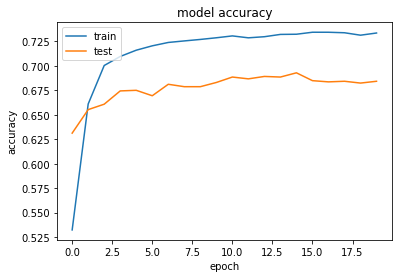

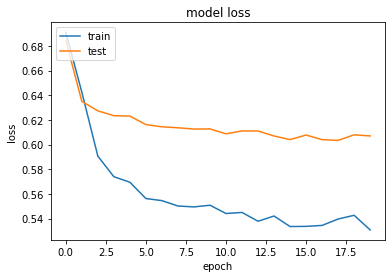

In [8]:
#collapse_hide
accuracy = results.history['win_output_accuracy']
val_accuracy = results.history['val_win_output_accuracy']
loss = results.history['win_output_loss']
val_loss = results.history['val_win_output_loss']
# summarize history for accuracy
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Results
The crossplots for point differential and win/loss are generally well behaved. The loss and accuracy of the model are not great in comparison to results from the Kaggle competition. For reference, anything below a loss of 0.5 would be considered fantastic and flipping a coin would give you a loss of about 0.69. We see a similar effect in the point spread prediction with a rather loose correlation of 0.46.

If the goal of this project was to have the best model for predicting the winner of an NCAA tournament game we would be failing (especially considering only the best play in the tournament - making predictions even harder). However, the goal here was to train embeddings not to get accurate predictions. Instead, we are using regular season data to train an embedding set that is representative of each team. We have only trained on wins/losses and points in this case, which might limit the utility of the features. Converserly, we will see in the next section that we have achieved a richer representation of the raw win/loss data than simply aggregating by teams.

Pearson coefficient:  0.46


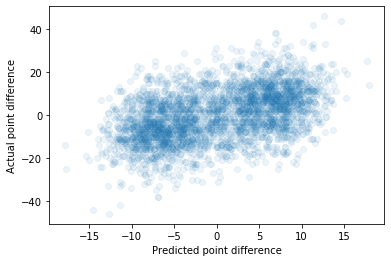

In [9]:
#collapse_hide
def transform_y(preds,stats_cache):
    preds = stats_cache['var'][1] * preds + stats_cache['mean'][1]
    return preds

preds = mymodel.predict(X_test)

tmp=0

x = transform_y(preds[1],stats_cache_train).reshape(-1)
y = transform_y(Y_norm_test[1],stats_cache_train).reshape(-1)


print('Pearson coefficient: ', round(stats.pearsonr(x, y)[0]*100)/100)
plt.scatter(x, y, alpha=0.08)
# plt.title('Scatter plot pythonspot.com')
plt.xlabel('Predicted point difference')
plt.ylabel('Actual point difference')
plt.show()

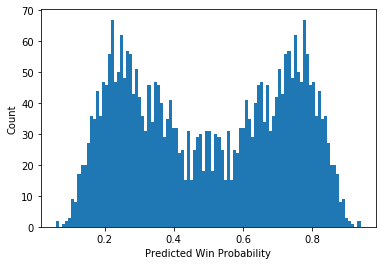

In [10]:
#collapse_hide
x = preds[0].reshape(-1)

plt.hist(x,bins=100)
# plt.title('Scatter plot pythonspot.com')
plt.xlabel('Predicted Win Probability')
plt.ylabel('Count')
plt.show()

One notable aspect of the point prediction result is that the predictions are perfectly symmetrical. The network is able to give consistent predictions for "Team A vs. Team B" and "Team B vs. Team A" because the neural network is set up to treat the input features consistently for each team. Other ML models, such as XGBoost, treat the feature inputs of Team 1 and Team 2 differently, which can result in varying predictions when the teams are swapped. This can be an issue even when training sets contain matchups **and** swapped matchups [as documented in this discussion](https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/discussion/130855).

## Exploratory Analysis
Let's take a look at some comparisons between our embeddings (mapped non-linearly into 2D space by T-SNE) vs. the aggregated point differential and win percentage of each team. All of these plots (excluding the final plot for 2020) will only include teams that were included in the NCAA tournament that year.

We'll color the scatter plots by a few different factors:
 - Highlighting tournament winners
 - Tournament seed number
 - Number of tournament games won
 - Biggest opening weekend upsets according to [this article](https://www.cbssports.com/college-basketball/news/march-madness-2019-the-10-biggest-upsets-ever-in-the-opening-weekend-of-the-tournament/)

Here is a preview of the data that will be fed into the visualizations:

In [11]:
#collapse_hide
embeddings = mymodel.layers[3].get_weights()[0]

t = TSNE(n_components=2)
embed_tsne = t.fit_transform(embeddings)

df_regSeason_full['T1_TeamName'] = df_regSeason_full['T1_TeamID'].apply(lambda x: teams_dict[x]) + '-' + df_regSeason_full['Season'].astype(str)
df_agg=df_regSeason_full.groupby('T1_TeamName').mean()
df_agg.reset_index(inplace=True,drop=False)
df_agg['Score_diff'] = -df_agg['Score_diff'] 
df_agg['Win'] = -df_agg['Win']
df_agg[['T1_TeamName','Win','Score_diff']]
df_agg.drop(columns='Season',inplace=True)

df_tourney_data = pd.read_csv(dataLoc/'MNCAATourneyCompactResults.csv')
df_tourney_data['WTeamName'] = df_tourney_data['WTeamID'].apply(lambda x: teams_dict[x]) + '-' + df_tourney_data['Season'].astype(str)
df_tourney_data['Wins'] = 0
df_wins = df_tourney_data[['WTeamName','Wins']].groupby('WTeamName').count()
tourneyWinners = [df_tourney_data.loc[df_tourney_data['Season']==s,'WTeamName'].values[-1] for s in df_tourney_data['Season'].unique()]

df_seeds = pd.read_csv(dataLoc/'MNCAATourneySeeds.csv')
df_seeds['TeamName'] = df_seeds['TeamID'].apply(lambda x: teams_dict[x]) + '-' + df_seeds['Season'].astype(str)
df_seeds['Seed'] = df_seeds['Seed'].str.extract(r'(\d+)')
df_seeds['WonTourney'] = df_seeds['TeamName'].apply(lambda x: True if x in tourneyWinners else False)
df_seeds = df_seeds[['TeamName','Seed','WonTourney']]

df_upsets = pd.read_csv('../input/ncaa-biggest-opening-weekend-upsets-from-cbs/Upsets.csv') # link to article: https://www.cbssports.com/college-basketball/news/march-madness-2019-the-10-biggest-upsets-ever-in-the-opening-weekend-of-the-tournament/
df_upsets['David']=df_upsets['David']+'-'+df_upsets['Season'].astype(str)
df_upsets['Goliath']=df_upsets['Goliath']+'-'+df_upsets['Season'].astype(str)
upsets = {}
for ii in df_upsets['David'].unique():
    upsets[ii] = 'Surprise'
for ii in df_upsets['Goliath'].unique():
    upsets[ii] = 'Bust'
df_seeds = pd.merge(left=df_seeds, right=df_wins, how='left', left_on='TeamName',right_index=True)
df_seeds['Wins'].fillna(0,inplace=True)

def upset(x):
    try:
        y = upsets[x]
    except:
        y = None
    return y
df_seeds['Upset'] = df_seeds['TeamName'].apply(lambda x: upset(x))

df = pd.DataFrame(embed_tsne,columns=['factor1','factor2'])
df['TeamName'] = [str(teams_dict[int(oh_to_id[x][-4:])]) + '-' + oh_to_id[x][:4] for x in df.index]
df['Season'] = [int(oh_to_id[x][:4])for x in df.index]

df = pd.merge(left=df, right=df_seeds, how='left', on='TeamName')
df = pd.merge(left=df, right=df_agg, how='left', left_on='TeamName',right_on='T1_TeamName')

df = df[['TeamName','Season','factor1','factor2','Win','Score_diff','Seed','Wins','Upset','WonTourney']]
df.columns = ['TeamName','Season','factor1','factor2','RegWins','RegPoint_diff','Seed','TourneyWins','Upset','WonTourney']

df2020 = df[df['Season']==2020].copy()

df.dropna(inplace=True,subset=['Seed'])

df['TourneyWinsScaled'] = df['TourneyWins']/df['TourneyWins'].max()
df['SeedScaled'] = df['Seed'].astype(int)/df['Seed'].astype(int).max()

df.head()

,TeamName,Season,factor1,factor2,RegWins,RegPoint_diff,Seed,TourneyWins,Upset,WonTourney,TourneyWinsScaled,SeedScaled
2,Alabama-1985,1985,-40.287521,-43.943745,-0.700000,-7.800000,07,2.0,None,False,0.333333,0.4375
8,Arizona-1985,1985,-36.456371,-27.896177,-0.666667,-7.185185,10,0.0,None,False,0.000000,0.6250
11,Arkansas-1985,1985,-39.831329,-22.700977,-0.636364,-3.636364,09,1.0,None,False,0.166667,0.5625
14,Auburn-1985,1985,-40.684334,-41.822636,-0.620690,-3.689655,11,2.0,None,False,0.333333,0.6875
21,Boston College-1985,1985,-36.670242,-45.133411,-0.615385,-5.269231,11,2.0,None,False,0.333333,0.6875


 > Important: For the following plots T-SNE representations of trained embeddings will be on the left and mean regular season statistics will be on the right. The aggregated statistics have also been multiplied by -1 to have a more similar graphical representation to the embeddings - Altair appears to not allow reversing both axes! :(

In [12]:
#collapse_hide
selector = alt.selection_single(empty='all', fields=['TeamName'])

base = alt.Chart(df).mark_point(filled=True,size=50).encode(
    color=alt.condition(selector,
                        alt.Color('WonTourney:N', scale=alt.Scale(scheme='tableau10')),
                        alt.value('lightgray') ),
    order=alt.Order('WonTourney:N', sort='ascending'),
    tooltip=['TeamName','Seed']
).properties(
    width=250,
    height=250
).add_selection(selector).interactive()

base.encode(alt.X('factor1:Q', scale=alt.Scale(domain=[-70,60])), alt.Y('factor2:Q', scale=alt.Scale(domain=[-75,50])) )  | base.encode( alt.X('RegPoint_diff:Q', scale=alt.Scale(domain=[-32,11])),alt.Y('RegWins:Q',scale=alt.Scale(domain=[-1.05,-.3])) )

alt.HConcatChart(...)

**Tournament winners compared to the field (above):** One interesting insight below is how significantly different the 1985 Villanova team is from the other tournament winners. Multiple websites ([like this one](https://www.saturdayeveningpost.com/2018/05/10-biggest-underdogs-win-championship/)) list the 1985 Villanova team winning the championship as one of the greatest underdog stories ever. This is far more evident in the T-SNE representation of the embeddings than the plots of win percentage vs. points.

In [13]:
#collapse_hide
selector = alt.selection_single(empty='all', fields=['TeamName'])

base = alt.Chart(df).mark_point(filled=True,size=35).encode(
    color=alt.condition(selector,
                        alt.Color('Seed:Q', scale=alt.Scale(scheme='viridis',reverse=True)),
                        alt.value('lightgray') ),
    order=alt.Order('Seed:Q', sort='descending'),
    tooltip=['TeamName','Seed']
).properties(
    width=250,
    height=250
).add_selection(selector).interactive()

base.encode( alt.X('factor1:Q', scale=alt.Scale(domain=[-70,60])), alt.Y('factor2:Q', scale=alt.Scale(domain=[-75,50])) )  | base.encode( alt.X('RegPoint_diff:Q', scale=alt.Scale(domain=[-32,11])),alt.Y('RegWins:Q',scale=alt.Scale(domain=[-1.05,-.3])) )

alt.HConcatChart(...)

**Colored by seed:** We see a high correlation between the assigned seed and our embeddings. Our embeddings appear to be a better representation of the seeding than the aggregated statistics, which makes sense since our method uses pair-wise comparisons and effectively accounts for team strength while aggregated statistics do not.

In [14]:
#collapse_hide
selector = alt.selection_single(empty='all', fields=['TeamName'])

base = alt.Chart(df).mark_point(filled=True,size=35).encode(
    color=alt.condition(selector,
                        alt.Color('TourneyWins:Q', scale=alt.Scale(scheme='viridis',reverse=False)),
                        alt.value('lightgray') ),
    order=alt.Order('TourneyWins:Q', sort='ascending'),
    tooltip=['TeamName','Seed']
).properties(
    width=250,
    height=250
).add_selection(selector).interactive()

base.encode( alt.X('factor1:Q', scale=alt.Scale(domain=[-70,60])), alt.Y('factor2:Q', scale=alt.Scale(domain=[-75,50])) )  | base.encode( alt.X('RegPoint_diff:Q', scale=alt.Scale(domain=[-32,11])),alt.Y('RegWins:Q',scale=alt.Scale(domain=[-1.05,-.3])) )

alt.HConcatChart(...)

**Colored by number of NCAA tournament games won that year:** The embeddings appear to be far less correlated to the number of games won by tournament. This is logical since, unlike the seeds, this statistic is not at all represented in the training set.

In [15]:
#collapse_hide
selector = alt.selection_single(empty='all', fields=['TeamName'])

base = alt.Chart(df).mark_point(filled=True,size=50).encode(
    color=alt.condition(selector,
                        alt.Color('Upset:N', scale=alt.Scale(scheme='tableau10')),
                        alt.value('lightgray') ),
    order=alt.Order('Upset:N', sort='ascending'),
    tooltip=['TeamName','Seed']
).properties(
    width=250,
    height=250
).add_selection(selector).interactive()

base.encode( alt.X('factor1:Q', scale=alt.Scale(domain=[-70,60])), alt.Y('factor2:Q', scale=alt.Scale(domain=[-75,50])) )  | base.encode( alt.X('RegPoint_diff:Q', scale=alt.Scale(domain=[-32,11])),alt.Y('RegWins:Q',scale=alt.Scale(domain=[-1.05,-.3])) )

alt.HConcatChart(...)

**Biggest upsets - underdogs in red:** Generally, the model agrees with the experts. These were upsets and wouldn't have been predicted by this method. If anything this method would likely have predicted *no upset* with even greater conviction tahn a model trained on just aggregated points and wins. The only exception to this is the 1986 "upset" of Cleveland State over the Indiana Hoosiers. Both the embeddings model and the aggregated statistics indicate that Cleveland State may have been the better team. Perhaps it was an issue of name recognition that lead this to be called an upset?

In [16]:
#collapse_hide
select_year = alt.selection_single(
    name='select', fields=['Season'], init={'Season': 1985},
    bind=alt.binding_range(min=1985, max=2019, step=1))

selector = alt.selection_single(empty='all', fields=['TeamName'])

##
base = alt.Chart(df).mark_point(filled=True,size=50).encode(
    color=alt.condition(selector,
                        alt.Color('TourneyWins:Q', scale=alt.Scale(scheme='viridis',reverse=False)),
                        alt.value('lightgray') ),
    order=alt.Order('Seed:Q', sort='descending'),
    tooltip=['TeamName','Seed']
).properties(
    width=250,
    height=250
).add_selection(select_year).transform_filter(select_year).add_selection(selector).interactive()

base.encode( alt.X('factor1:Q', scale=alt.Scale(domain=[-70,60])), alt.Y('factor2:Q', scale=alt.Scale(domain=[-75,50])) )  | base.encode( alt.X('RegPoint_diff:Q', scale=alt.Scale(domain=[-32,11])),alt.Y('RegWins:Q',scale=alt.Scale(domain=[-1.05,-.3])) )

alt.HConcatChart(...)

**Number of games won split out by season - yellow dot is tournament winner**: The spread of teams is quite variable year to year. Notably, the tournament that the 1985 Villanova team won as a heavy underdog has less spread in the competition than other years.

In [17]:
#collapse_hide
## 2020 plot
selector = alt.selection_single(empty='all', fields=['TeamName'])

base = alt.Chart(df2020).mark_point(filled=True,size=50).encode(
    color=alt.condition(selector,
                        alt.Color('TeamName:N'),
                        alt.value('lightgray') ),
    order=alt.Order('RegWins:Q', sort='ascending'),
    tooltip=['TeamName']
).properties(
    width=250,
    height=250
).add_selection(selector).interactive()

base.encode( alt.X('factor1:Q', scale=alt.Scale(domain=[-70,60])), alt.Y('factor2:Q', scale=alt.Scale(domain=[-65,75])) )  | base.encode( alt.X('RegPoint_diff:Q', scale=alt.Scale(domain=[-21,26])),alt.Y('RegWins:Q',scale=alt.Scale(domain=[-1,0])) )

alt.HConcatChart(...)

**The 2020 field:** Just for fun here is a taste of what we missed in 2020!

## Conclusions
The embeddings apppear to have learned which teams are better and which are worse. It seems that they are a better representation of true team skill than simple aggregating the statistics used in model training (wins and point differentials). When the time comes to build a model for the 2021 March Madness Kaggle competition, I will likely return to embeddings as an advanced input feature for my final model, which will be trained on real tournament games! Then will be the time to experiment with training the team embeddings on advanced statistics included in the detailed Kaggle data set in place of or in addition to the target features used here.

